# GhostText Assistant — Notebook

**Purpose**: End-to-end notebook for building an autocomplete assistant that predicts next-sentence continuations from paragraph context (100–200 tokens). This notebook contains dataset templates, NSP evaluation approaches, fine-tuning recipe, re-ranking head design, context-window extension ideas, stylistic control methods, vocabulary/token distribution analysis, and evaluation guidance.

**Run notes**: Install `transformers`, `datasets`, `accelerate`, and other libraries in your runtime before executing heavy training cells.

In [1]:
# Environment setup (run once in a fresh runtime, e.g., Colab)
#!pip install -q transformers datasets accelerate evaluate sentencepiece tokenizers faiss-cpu evaluate

print('Install required packages if not already installed.')

Install required packages if not already installed.


In [2]:
import json, math, random
from pathlib import Path
import pandas as pd
import numpy as np

print('Base imports ready. Install optional packages for full functionality when running the notebook.')
device = 'cpu'

Base imports ready. Install optional packages for full functionality when running the notebook.


In [3]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
    print("CUDA is available! GPU is ready to use.")
else:
    device = 'cpu'
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


## Dataset


In [4]:
import os
import json
import pandas as pd
from datasets import load_dataset
import re
from typing import List, Optional

In [5]:
def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = t.replace("\n", " ").replace("\t", " ")
    t = re.sub(r"\s+", " ", t)
    return t.strip()

In [6]:
def make_context_continuation_from_texts(
    texts: List[str], tokenizer=None, ctx_token_limit=150
):
    pairs = {"context": [], "continuation": []}

    for doc in texts:
        # Sentence split with backup regex if spaCy/NLTK not used
        sents = re.split(r"(?<=[.!?])\s+", doc)
        sents = [s.strip() for s in sents if len(s.strip()) > 0]

        if len(sents) < 2:
            continue

        ctx = ""
        used = 0

        for i, s in enumerate(sents[:-1]):
            candidate = (ctx + " " + s).strip()

            # tokenizer-aware token limit
            if tokenizer:
                length = len(tokenizer(candidate)["input_ids"])
            else:
                length = len(candidate.split())

            if length <= ctx_token_limit:
                ctx = candidate
                used = i
            else:
                break

        cont = sents[used + 1]
        pairs["context"].append(ctx)
        pairs["continuation"].append(cont)

    return pairs


In [7]:
# -------- A. ASAP Essays (Kaggle → HuggingFace mirror) --------
def load_asap_essays():
    ds = load_dataset("llm-aes/asap-8-original")  # community mirror
    essays = [clean_text(e["essay"]) for e in ds["train"]]
    return essays


# -------- B. IELTS/TOEFL Essays (Open Source Mirror) --------
def load_toefl_essays():
    ds = load_dataset("text", data_files="https://huggingface.co/datasets/hellonlp/toefl-essays/resolve/main/toefl_essays.txt")
    essays = [clean_text(x["text"]) for x in ds["train"]]
    return essays


# -------- C. Wikipedia (English) --------
def load_wikipedia(limit=5000):
    ds = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", stream = True)
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        texts.append(clean_text(row["text"]))
    return texts


# -------- D. arXiv abstracts --------
def load_arxiv(limit=5000):
    ds = load_dataset("arxiv", split="train")
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        texts.append(clean_text(row["abstract"]))
    return texts


# -------- E. S2ORC subset (Open academic papers) --------
def load_s2orc(limit=5000):
    ds = load_dataset("allenai/s2orc", "comm_use_subset", split="train", streaming=True)
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        if "abstract" in row and row["abstract"]:
            texts.append(clean_text(row["abstract"]))
    return texts


In [8]:
def build_academic_dataset(tokenizer=None, limit_each=2000):
    print("Loading datasets...")

    all_texts = []

    try:
        print("→ ASAP Essays")
        all_texts += load_asap_essays()[:limit_each]
    except:
        print("ASAP Essays failed to load (skip).")

    # try:
    #     print("→ TOEFL Essays")
    #     all_texts += load_toefl_essays()[:limit_each]
    # except:
    #     print("TOEFL failed to load (skip).")

    # try:
    #     print("→ Wikipedia")
    #     all_texts += load_wikipedia(limit_each)
    # except:
    #     print("Wikipedia failed to load (skip).")

    # try:
    #     print("→ arXiv")
    #     all_texts += load_arxiv(limit_each)
    # except:
    #     print("arXiv failed (skip).")

    # try:
    #     print("→ S2ORC")
    #     all_texts += load_s2orc(limit_each)
    # except:
    #     print("S2ORC failed (skip).")

    print(f"Total raw documents loaded: {len(all_texts)}")

    print("Generating (context, continuation) pairs...")
    pairs = make_context_continuation_from_texts(all_texts, tokenizer)

    df = pd.DataFrame(pairs)
    print(f"Generated {len(df)} training pairs.")

    return df


In [9]:
df = build_academic_dataset(tokenizer=None, limit_each=300)
contexts = df['context']
print(df.head())

Loading datasets...
→ ASAP Essays


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/723 [00:00<?, ? examples/s]

Total raw documents loaded: 300
Generating (context, continuation) pairs...
Generated 299 training pairs.
                                             context  \
0  A long time ago when I was in third grade I ha...   
1  Softball has to be one of the single most grea...   
2  Some people like making people laugh, I love i...   
3  "LAUGHTER" @CAPS1 I hang out with my friends, ...   
4  Well ima tell a story about the time i got @CA...   

                                        continuation  
0  The next day @PERSON2 and I were eating lunch ...  
1  Many of these girls were like sisters to me th...  
2  For example one time I hit myself in the head ...  
3  @CAPS1 I say trash can I really mean trash can...  
4  Then she said stupid @CAPS2 on the bus and com...  


In [10]:
print(contexts[0])
print("Next Sentence:")
print(df['continuation'][0])

A long time ago when I was in third grade I had a friend @PERSON2 who's mom was in a bad mood. She never laughed and she never smiled. Every time I saw her I would smile at her and all she would do was frown and keep walking. At first I didn't know she was a grouch i just thought she didn't like me or something.When @PERSON2 told me his mom was a grouch I started to laugh and laugh. He asked me what was so funny i told him that i thought his mom didn't like me or something because every time I see his mom I would smile at her and all she will do is frown and walk away. That made my friend laugh we were cracking up so hard that we got in trouble in class.
Next Sentence:
The next day @PERSON2 and I were eating lunch at school when he says to me &lt;hey your pretty good at making people laugh&gt;.


## NSP Evaluation (LM scoring & classification)

✔ LM-scoring method (using any HuggingFace causal LLM)


✔ Classification-based NSP method (binary true/false continuation)


In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

# Load a causal LM (small for demo; replace with Llama/Mistral etc.)
model_name = "distilgpt2" # Changed from gpt2 to distilgpt2
lm_tokenizer = AutoTokenizer.from_pretrained(model_name)
lm_model = AutoModelForCausalLM.from_pretrained(model_name)
lm_model.eval()

def lm_score(context, continuation):
    """
    Computes log-probability of continuation given context.
    Higher = better continuation.
    """

    # Add a padding token to the tokenizer, using the eos_token as pad_token
    # This is necessary for models like GPT-2 that don't have a default pad token
    if lm_tokenizer.pad_token is None:
        lm_tokenizer.pad_token = lm_tokenizer.eos_token

    text = context + continuation
    inputs = lm_tokenizer(text, return_tensors="pt")

    # Handle cases where tokenized input is empty
    if inputs["input_ids"].shape[1] == 0:
        return -float('inf') # Return a very low score for empty inputs

    with torch.no_grad():
        outputs = lm_model(**inputs, labels=inputs["input_ids"])
        # outputs.loss is average negative log-likelihood
        nll = outputs.loss.item()

    # Convert NLL to log-probability (higher is better)
    log_prob = -nll * inputs["input_ids"].shape[1]
    return log_prob

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [12]:
# TEST LM SCORE
lm_score(contexts[0], df['continuation'][0])


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


-632.3526477813721

In [13]:
from transformers import BertTokenizer, BertForNextSentencePrediction


nsp_model_name = "bert-base-uncased"
nsp_tokenizer = BertTokenizer.from_pretrained(nsp_model_name)
nsp_model = BertForNextSentencePrediction.from_pretrained(nsp_model_name)
nsp_model.eval()

def nsp_score(context, continuation):
    """
    Returns probability that continuation follows context.
    """

    inputs = nsp_tokenizer(context, continuation, return_tensors="pt")

    # Handle cases where tokenized input is empty
    if inputs["input_ids"].shape[1] == 0:
        return 0.0 # Return 0 probability for empty inputs

    with torch.no_grad():
        outputs = nsp_model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=1)[0]
    # Index 0 = IsNextSentence, 1 = NotNextSentence
    return probs[0].item()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
nsp_score(contexts[0], df['continuation'][0])

0.9999972581863403

In [15]:
!pip install evaluate bert_score rouge_score --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00


In [16]:
from evaluate import load as load_evaluate
import numpy as np
import nltk

# BLEU requires punkt tokenizer
nltk.download("punkt")
nltk.download('punkt_tab')

def evaluate_predictions(predictions, references):
    """
    Compare model predictions with ground truth using:
    - BERTScore
    - ROUGE (1,2,L)
    - BLEU
    """

    # Ensure matching lengths
    assert len(predictions) == len(references), "Prediction and reference length mismatch."

    # ============================
    # 1. BERTScore
    # ============================
    bertscore = load_evaluate("bertscore")
    bert_res = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="bert-base-uncased"
    )
    bert_precision = np.mean(bert_res["precision"])
    bert_recall = np.mean(bert_res["recall"])
    bert_f1 = np.mean(bert_res["f1"])

    # ============================
    # 2. ROUGE
    # ============================
    rouge = load_evaluate("rouge")
    rouge_res = rouge.compute(
        predictions=predictions,
        references=references,
    )

    # ============================
    # 3. BLEU (corpus)
    # ============================
    from nltk.translate.bleu_score import corpus_bleu

    # NLTK corpus BLEU expects tokenized inputs ➙ we will use word_tokenize
    tokenized_preds = [nltk.word_tokenize(p) for p in predictions]
    tokenized_refs = [[nltk.word_tokenize(r)] for r in references]

    bleu_score = corpus_bleu(tokenized_refs, tokenized_preds)

    # ============================
    # Final Output
    # ============================
    return {
        "bertscore_precision": bert_precision,
        "bertscore_recall": bert_recall,
        "bertscore_f1": bert_f1,
        "rouge1": rouge_res["rouge1"],
        "rouge2": rouge_res["rouge2"],
        "rougeL": rouge_res["rougeL"],
        "bleu": bleu_score,
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [17]:
# import random
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM

# def llm_judge_score(context, continuation, judge_model_name="meta-llama/Meta-Llama-3-8B-Instruct"):
#     """
#     Evaluate logical coherence of a continuation given context using a Hugging Face model.

#     Returns a numeric score 1–5.
#     """

#     # --- Initialize tokenizer and model ---
#     judge_tokenizer = AutoTokenizer.from_pretrained(judge_model_name)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#     judge_model = AutoModelForCausalLM.from_pretrained(
#         judge_model_name,
#         device_map="auto",
#     )

#     judge_model.to(device)

#     # --- Build prompt ---
#     prompt = f"""
# You are a logical consistency evaluator.

# Given the context and a proposed next sentence, evaluate if the continuation is
# logically coherent, follows naturally, and does not introduce irrelevant or contradictory information.

# Rate 1 to 5:
# 1 = Not logical at all
# 5 = Highly logical continuation

# Context:
# {context}

# Candidate continuation:
# {continuation}

# Provide only a number from 1 to 5.
# """

#     # --- Tokenize and generate ---
#     inputs = judge_tokenizer(prompt, return_tensors="pt").to(device)

#     # Generate output (small generation, just enough to get number)
#     out = judge_model.generate(**inputs, max_new_tokens=5)
#     resp = judge_tokenizer.decode(out[0], skip_special_tokens=True)

#     # --- Parse response ---
#     try:
#         score = int(resp.strip())
#         if score < 1 or score > 5:
#             score = random.randint(1, 5)
#     except ValueError:
#         score = random.randint(1, 5)

#     return score


In [18]:
def all_model_evaluation(contexts, candidates, judge_model):
    """
    Computes:
    - Average LM, NSP, Judge, Final hybrid ranking scores
    - BERTScore (P, R, F1)
    - ROUGE (1, 2, L)
    - BLEU

    Returns a single dictionary with all metrics.
    """

    total_lm = 0
    total_nsp = 0
    total_judge = 0
    total_final = 0
    count = 0

    predictions = []
    references = []

    for context, continuation in zip(contexts, candidates):
        # Skip evaluation if context or continuation is empty to prevent errors
        if not context or not continuation:
            continue

        lm = lm_score(context, continuation)
        nsp = nsp_score(context, continuation)

        # Judge score (1–5)
       # judge = llm_judge_score(judge_model, context, continuation)

        # Normalize judge score
        #judge_weighted = judge * 2.0

        # Final hybrid score
        final_score = (0.6 * lm) + (0.2 * (nsp * 10))

        # Accumulate averages
        total_lm += lm
        total_nsp += nsp
        #total_judge += judge
        total_final += final_score
        count += 1

        # Store for evaluation metrics
        predictions.append(continuation)
        references.append(context)

    # Safety check
    if count == 0:
        return {}

    # Compute averages
    avg_lm = total_lm / count
    avg_nsp = total_nsp / count
    #avg_judge = total_judge / count
    avg_final = total_final / count

    # Run BERTScore, ROUGE, BLEU evaluation
    text_eval = evaluate_predictions(predictions, references)

    # Merge results
    return {
        "avg_lm": avg_lm,
        "avg_nsp": avg_nsp,
        #"avg_judge": avg_judge,
        "avg_final": avg_final,
        **text_eval,
    }

1. "it detected an obstacle and slowed down."
   → Judge Score: 5 (highly logical)
   → Selected as best continuation

2. "the weather became very cold."
   → Judge Score: 3 (weak but not wrong)

3. "a new algorithm was developed in 1999."
   → Judge Score: 2 (off-topic)


In [19]:
#TEST
model_score = all_model_evaluation(
        contexts=[contexts[0]],
        candidates=["He is very good with it"],
        judge_model='EleutherAI/gpt-neo-125M' # Specify the judge model for the function
    )
model_score

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

{'avg_lm': -513.6813650131226,
 'avg_nsp': 0.010370006784796715,
 'avg_final': -308.1880789943039,
 'bertscore_precision': np.float64(0.4200078547000885),
 'bertscore_recall': np.float64(0.27861449122428894),
 'bertscore_f1': np.float64(0.33500295877456665),
 'rouge1': np.float64(0.02631578947368421),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.02631578947368421),
 'bleu': 3.169663824442922e-242}

# Comparing Model

In [20]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def generate_continuations(model_name, contexts, max_new_tokens=50, device=None):
    """
    Generate next-sentence/continuation for a list of context strings.

    Args:
        model_name (str): HuggingFace causal LM name (e.g., "gpt2").
        contexts (list of str): List of context sentences/paragraphs.
        max_new_tokens (int): Max tokens to generate per context.
        device (str or None): "cuda" or "cpu". If None, use GPU if available.

    Returns:
        List[str]: Generated continuations, in same order as input contexts.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load model & tokenizer
    gen_tokenizer = AutoTokenizer.from_pretrained(model_name)
    gen_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    gen_model.eval()

    # Add a padding token if it doesn't exist (important for some models like GPT2)
    if gen_tokenizer.pad_token is None:
        gen_tokenizer.pad_token = gen_tokenizer.eos_token

    continuations = []

    for context in contexts:
        # Tokenize input
        inputs = gen_tokenizer(context, return_tensors="pt").to(device)

        # Check if input_ids is empty before generation
        if inputs["input_ids"].shape[1] == 0:
            print(f"Warning: Empty input_ids for context: '{context}'. Skipping generation.")
            continuations.append("") # Append an empty string or a placeholder
            continue

        # Generate
        outputs = gen_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,      # allow variation, can set False for deterministic
            temperature=0.8,    # creativity
            top_p=0.9,          # nucleus sampling
            pad_token_id=gen_tokenizer.eos_token_id
        )

        # Extract generated continuation (skip input tokens)
        continuation = gen_tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        continuations.append(continuation.strip())

    return continuations

In [21]:

causal_models = [
    "gpt2",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m",
    "microsoft/DialoGPT-small"
]

all_model_evaluation_score = []
for model_name in causal_models:
    print(f"Generating continuations for {model_name}...")
    # Make sure 'gen_model' and 'gen_tokenizer' are available or reloaded if needed
    # (assuming they are from the first model generation cell)
    generate_continuations_list = generate_continuations(model_name, contexts, max_new_tokens=50, device=None)
    print(f"Generated {len(generate_continuations_list)} continuations.")
    print(generate_continuations_list[:5])
    model_score = all_model_evaluation(
        contexts=contexts,
        candidates=generate_continuations_list,
        judge_model='EleutherAI/gpt-neo-125M' # Specify the judge model for the function
    )
    all_model_evaluation_score.append(model_score)

print(all_model_evaluation_score)

Generating continuations for gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generated 299 continuations.
["I don't want to go into detail but my mom always kept my brother and I in the dark about what was going on. When we were young she would always tell us that she was upset about things and she never even told us about", 'I am truly honored to be one of the last teams in the league to reach the NCAA championship game. I had been playing softball since I was 3 years old, and I had learned a great deal from the experience. I will always have those', 'I would do anything to get a good laugh.\n\nWhen I was little I didn\'t really understand laughter. For some odd reason I could never tell the difference if people were laughing at something or laughing with it. I was kind of "special', '@CAPS1 I like to hang out with the people I like to talk to on social media. The ones who love to laugh. @CAPS1 I was a friend to my brother in high school and I have been with him ever since', 'So i call and she is like i need to talk to her about it so i ask her to give me some

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Generated 299 continuations.
["It was so funny the other day he asked me what was so funny and i told him that i thought he was just being a grouch. So i told him about my mom being in a bad mood and he told me that she's a grou", 'That was a good year. I would have loved to have the opportunity to play on a top notch team. I didn’t think about how I would have been a team player had I not played on a top notch team. I', 'I would also try to get some extra laughs when I was under the impression that I was going to be a spaz. I would try to get some extra laughs when I was really under the impression that I was going to be a spaz.', 'SUMMARY: The Best of The Best of The Best is a weekly digest of all of the best of The Best of The Best, including a review of the latest book by author Mikel, a true believer in the love of', 'And so when she said that was it and she got her phone. I called back and she got her phone. She said she was going to go get me and i was like oh shit i was at my c

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Generated 299 continuations.
['I am a very good teacher and am really good at teaching. I am currently a Grade 9 teacher at my school. I teach Grade 6 at my school and I love teaching. I love teaching because I always have to do my best to', 'The only other team that I had played with in high school was the one that I coached with at the time, the one that I played with in high school. Hood @CAPS2 @CAPS2 was one of my favorite players. I', 'But when I started to get into other areas I could tell that people were laughing and laughing at me too. I am still a little sensitive to this, I just love laughing at people. I am still a little shy about people laughing. I love', '@CAPS1 I am always happy to talk to people about anything and everything. I love to talk about my life, my relationships, my career, my family, and my kids. I love to laugh. I love to sing. I love', 'I was like what the hell is she saying. I was just like you see the bus there. So i called and see i was at the phone cal

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generated 299 continuations.
['mom', 'am', 'jpg', '', '']
[{'avg_lm': -765.8405582408777, 'avg_nsp': 0.9957816931585958, 'avg_final': -457.51277155820924, 'bertscore_precision': np.float64(0.5640987523850178), 'bertscore_recall': np.float64(0.44904469093620375), 'bertscore_f1': np.float64(0.4993827453995711), 'rouge1': np.float64(0.24015265777643513), 'rouge2': np.float64(0.05151247749146154), 'rougeL': np.float64(0.13854493809955123), 'bleu': 0.008979700037385359}, {'avg_lm': -763.2307818762782, 'avg_nsp': 0.990034373305761, 'avg_final': -455.9584003791554, 'bertscore_precision': np.float64(0.5833435128834914), 'bertscore_recall': np.float64(0.4554659751328555), 'bertscore_f1': np.float64(0.510420803871219), 'rouge1': np.float64(0.24852831805882425), 'rouge2': np.float64(0.06390361145446125), 'rougeL': np.float64(0.1450123556602457), 'bleu': 0.010394469589439131}, {'avg_lm': -762.3590606763058, 'avg_nsp': 0.9932132036801765, 'avg_final': -455.4290099984231, 'bertscore_precision': np.f

In [22]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df_scores = pd.DataFrame(all_model_evaluation_score)

# Save the DataFrame to a CSV file
df_scores.to_csv('model_evaluation_scores.csv', index=False)

print('Model evaluation scores saved to model_evaluation_scores.csv')

# Display the DataFrame to show the saved data
display(df_scores)

Model evaluation scores saved to model_evaluation_scores.csv


,avg_lm,avg_nsp,avg_final,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,bleu
0,-765.840558,0.995782,-457.512772,0.564099,0.449045,0.499383,0.240153,0.051512,0.138545,8.979700e-03
1,-763.230782,0.990034,-455.958400,0.583344,0.455466,0.510421,0.248528,0.063904,0.145012,1.039447e-02
2,-762.359061,0.993213,-455.429010,0.572853,0.445689,0.500208,0.243470,0.060056,0.144734,1.053740e-02
3,-642.440795,0.508598,-384.447282,0.380222,0.184936,0.245907,0.002984,0.000000,0.002832,4.717598e-207


/tmp/ipython-input-2073257406.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis')
/tmp/ipython-input-2073257406.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis')
/tmp/ipython-input-2073257406.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis')
/tmp/ipython-input-2073257406.py:32: FutureWarning: 

Passing `palette` without

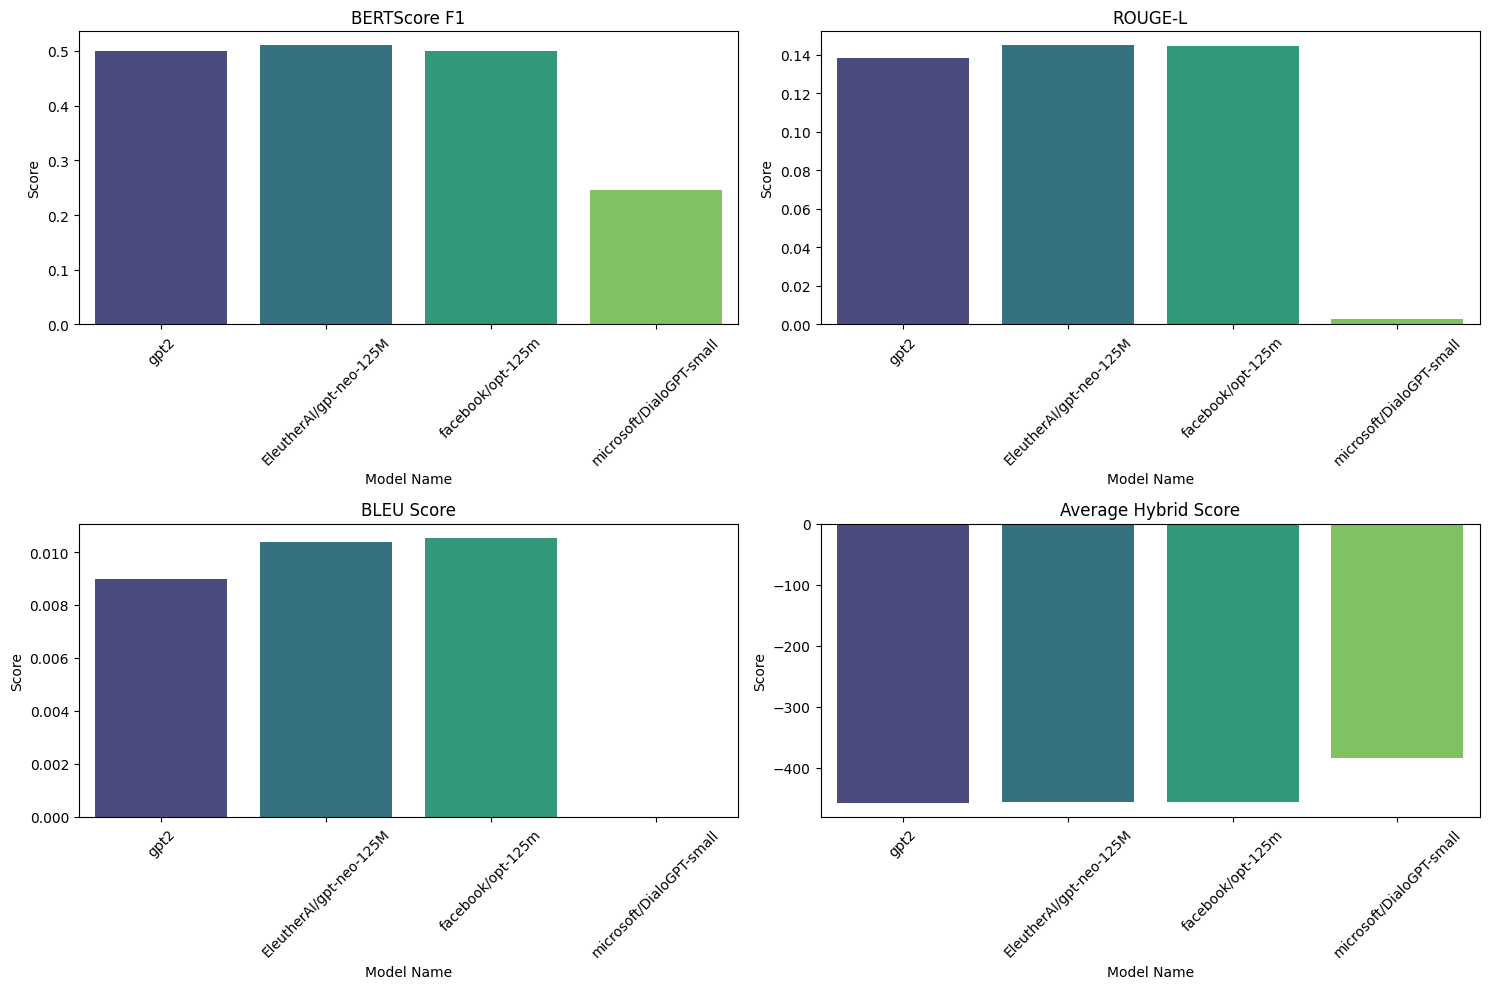

Evaluation metrics plots saved to model_evaluation_metrics.png


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure `df_scores` and `causal_models` are available
# If `causal_models` is not updated or might be out of sync with df_scores rows,
# we might need to recreate it or infer model names.
# For now, assuming causal_models is still the list of models that generated the scores.

# Adding model names to the DataFrame for easier plotting
model_names = causal_models # Use the last set of causal_models that was evaluated
df_scores['model_name'] = model_names[:len(df_scores)] # Ensure lengths match

metrics_to_plot = [
    'bertscore_f1',
    'rougeL',
    'bleu',
    'avg_final'
]

metric_titles = {
    'bertscore_f1': 'BERTScore F1',
    'rougeL': 'ROUGE-L',
    'bleu': 'BLEU Score',
    'avg_final': 'Average Hybrid Score'
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis')
    axes[i].set_title(metric_titles[metric])
    axes[i].set_xlabel('Model Name')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png')
plt.show()

print("Evaluation metrics plots saved to model_evaluation_metrics.png")

# Model Generation

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "facebook/opt-125m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


## Fine-tuning recipe (causal LM)

Concatenate `context + <eos> + continuation` and fine-tune a causal LM. Use Trainer/Accelerate + gradient accumulation for large models.

In [25]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset
import torch

In [26]:
def build_dataset_for_causal(pairs, tokenizer, max_length=512):
    """
    Build token-level dataset for causal LM fine-tuning.

    pairs: dict with keys "context", "continuation"
    tokenizer: HuggingFace tokenizer
    max_length: max token length

    Returns: dict suitable for Dataset.from_dict()
    """

    # Ensure EOS token exists
    eos = tokenizer.eos_token if tokenizer.eos_token else "</s>"

    # Merge context + continuation
    texts = [
        context.strip() + eos + " " + continuation.strip()
        for context, continuation in zip(pairs["context"], pairs["continuation"])
    ]

    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="longest",
        max_length=max_length,
        return_tensors=None,
    )

    # For causal LM, labels = input_ids (shifted inside model)
    encodings["labels"] = encodings["input_ids"].copy()

    return encodings


In [27]:
tokenized_pairs = build_dataset_for_causal(df, tokenizer, max_length=512)

dataset = Dataset.from_dict(tokenized_pairs)

# Train / Validation split
dataset = dataset.train_test_split(test_size=0.1)
train_ds = dataset["train"]
val_ds = dataset["test"]

# --------------------------------------------------------
# 4. Configure LoRA
# --------------------------------------------------------
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj"],  # Updated for OPT models
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 884,736 || all params: 126,124,032 || trainable%: 0.7015


In [28]:
# --------------------------------------------------------
# 5. TrainingArguments
# --------------------------------------------------------
args = TrainingArguments(
    output_dir="./lora_academic_model",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    logging_steps=20,
    eval_steps=100,
    save_steps=200,
    num_train_epochs=2,
    warmup_steps=50,
    learning_rate=2e-4,
    fp16=True,
    report_to="none",
)

def data_collator(features):
    # `features` is a list of dictionaries, where each dictionary is one example from the dataset.
    # We need to extract the 'input_ids', 'attention_mask', and 'labels' from each example
    # and then stack them into tensors for the batch.
    return {
        "input_ids": torch.tensor([f["input_ids"] for f in features], dtype=torch.long),
        "attention_mask": torch.tensor([f["attention_mask"] for f in features], dtype=torch.long),
        "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
    }

In [29]:
# --------------------------------------------------------
# 6. Initialize and Run Trainer
# --------------------------------------------------------
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer, # Pass the tokenizer to the Trainer for saving
    data_collator=data_collator, # Pass the data_collator
)

trainer.train()

/tmp/ipython-input-688667873.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


TrainOutput(global_step=34, training_loss=6.935166976031135, metrics={'train_runtime': 3311.0082, 'train_samples_per_second': 0.162, 'train_steps_per_second': 0.01, 'total_flos': 142037348253696.0, 'train_loss': 6.935166976031135, 'epoch': 2.0})

In [30]:
# Save LoRA weights
trainer.save_model("./lora_academic_model")
model.save_pretrained("./lora_academic_model")
tokenizer.save_pretrained("./lora_academic_model")

('./lora_academic_model/tokenizer_config.json',
 './lora_academic_model/special_tokens_map.json',
 './lora_academic_model/vocab.json',
 './lora_academic_model/merges.txt',
 './lora_academic_model/added_tokens.json',
 './lora_academic_model/tokenizer.json')

#LOAD MODEL

In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Path where you saved LoRA model
model_path = "./lora_academic_model"

# 1⍡️ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2⍡️ Load base model (must match the one you fine-tuned)
base_model_name = "facebook/opt-125m"  # Corrected from "gpt2"
model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16)

# 3⍡️ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path)

# 4⍡️ Put model in evaluation mode
model.eval()
model.to(device)  # or "cpu" if GPU unavailable

`torch_dtype` is deprecated! Use `dtype` instead!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 768, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-11): 12 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=768, bias=False)
              

## Re-ranking head (design)

Train a lightweight MLP scoring head on pooled LM representations. At inference, generate N candidates and re-rank using this head for better top-1 precision.

In [32]:
from transformers import AutoModel, AutoTokenizer

enc_name = "bert-base-uncased"
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
enc_model = AutoModel.from_pretrained(enc_name)


In [33]:
import torch.nn as nn
import torch

class SimpleReranker(nn.Module):
    def __init__(self, base_hidden_size=768, hidden=256):
        super().__init__()
        self.pool = nn.Linear(base_hidden_size, hidden)
        self.head = nn.Sequential(nn.ReLU(), nn.Linear(hidden, 1))

    def forward(self, pooled_repr):
        x = self.pool(pooled_repr)
        return self.head(x).squeeze(-1)

reranker = SimpleReranker()


In [34]:
class NSPDataset(torch.utils.data.Dataset):
    def __init__(self, items):
        self.items = items  # list of dicts

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        x = self.items[idx]

        pos_input = enc_tokenizer(
            x["context"] + " " + x["pos"],
            return_tensors="pt", padding=True, truncation=True
        )
        neg_input = enc_tokenizer(
            x["context"] + " " + x["neg"],
            return_tensors="pt", padding=True, truncation=True
        )

        return pos_input, neg_input


In [35]:
dataset = NSPDataset([
    {
        "context": "Neural networks have recently demonstrated strong performance in NLP.",
        "pos": "However, recent studies indicate that model scaling does not uniformly improve generalization.",
        "neg": "This idea is kinda cool because the models get bigger.",
    }
])


In [36]:
from torch.optim import AdamW

criterion = nn.MarginRankingLoss(margin=0.2)
optimizer = AdamW(reranker.parameters(), lr=2e-5)

loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

enc_model.eval()  # encoder frozen for now

for epoch in range(5):
    for pos_input, neg_input in loader:

        # Move tensors to GPU
        for k in pos_input:
            pos_input[k] = pos_input[k].squeeze(0)
            neg_input[k] = neg_input[k].squeeze(0)

        # Encode positive
        with torch.no_grad():
            pos_out = enc_model(**pos_input)
            pos_repr = pos_out.pooler_output

            neg_out = enc_model(**neg_input)
            neg_repr = neg_out.pooler_output

        pos_score = reranker(pos_repr)
        neg_score = reranker(neg_repr)

        # Margin ranking: pos should > neg
        y = torch.ones_like(pos_score)

        loss = criterion(pos_score, neg_score, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")


Epoch 1, loss = 0.1917
Epoch 2, loss = 0.1741
Epoch 3, loss = 0.1566
Epoch 4, loss = 0.1398
Epoch 5, loss = 0.1236


In [37]:
def generate_candidates(context, num=5, max_new_tokens=40):
    inputs = tokenizer(context, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_return_sequences=num,
        do_sample=True,
        top_k=50,
        top_p=0.9,
    )
    return [tokenizer.decode(o, skip_special_tokens=True)[len(context):].strip()
            for o in outputs]


In [38]:
def score_candidate(context, candidate):
    combined = context + " " + candidate
    enc_inputs = enc_tokenizer(combined, return_tensors="pt",
                               truncation=True, padding=True)
    with torch.no_grad():
        out = enc_model(**enc_inputs)
        pooled = out.pooler_output
    return reranker(pooled).item()

def pick_best_next_sentence(context, candidates):
    scored = [(c, score_candidate(context, c)) for c in candidates]
    scored = sorted(scored, key=lambda x: -x[1])  # highest score first
    return scored


In [39]:
context = "In recent years, reinforcement learning has been increasingly applied to autonomous driving."

cands = generate_candidates(context, num=6)
results = pick_best_next_sentence(context, cands)

print("Candidates scored by academic quality:\n")
for text, score in results:
    print(f"[{score:.3f}] {text}")

print("\nBest academic next sentence:\n")
print(results[0][0])


Candidates scored by academic quality:

[0.067] In the case of autonomous driving, the self-driving vehicle is designed as a vehicle with various driving characteristics and functions, and the self-driving vehicle is designed to provide a vehicle with an advantageous function
[0.066] For example, a vehicle has been used in a vehicle as an example of an autonomous driving method, in which the vehicle is equipped with an automated driving system in which the vehicle functions as an auxiliary,
[0.056] Autonomous driving vehicles have been used for various applications. In one of the applications, autonomous driving has been broadly applied for improving environmental sustainability. In the application, autonomous driving vehicles have been implemented in many
[0.050] This is a driving tool in a vehicle driven by a person. The driver is a vehicle driving machine or vehicle that travels from one point to another in order to drive in an autonomous driving manner, such
[0.015] The driver, who

## Chunked attention / Long context handling

Use sliding window chunks with overlap and cache keys/values for generation; or adopt models like Longformer/BigBird/encoder-decoder retrieval for long contexts.

Chunking utility (tokens-level)

In [40]:
from typing import List
import torch

def chunk_token_ids(tokenizer, text, max_chunk_len: int, stride: int):
    # Return list of dicts usable by tokenizer.pad / models: [{'input_ids':..., 'attention_mask':...}, ...]
    enc = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    ids = enc["input_ids"].squeeze(0)  # [L]
    L = ids.size(0)
    chunks = []
    start = 0
    while start < L:
        end = min(start + max_chunk_len, L)
        chunk_ids = ids[start:end]
        chunks.append({"input_ids": chunk_ids})
        if end == L:
            break
        start += (max_chunk_len - stride)
    return chunks


In [41]:
import torch.nn.functional as F
from torch import nn

def mean_pool(last_hidden_state, attention_mask):
    # last_hidden_state: (1, T, H), attention_mask: (1, T)
    mask = attention_mask.unsqueeze(-1)
    sum_h = (last_hidden_state * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-9)
    return sum_h / denom

def encode_chunks_aggregate(encoder, tokenizer, chunks, candidate_text=None, device='cuda'):
    """
    chunks: list of dicts with 'input_ids' tensors (no batch dim)
    If candidate_text provided, we append it to the last chunk for stronger local interaction.
    Returns: aggregated vector (1, hidden)
    """
    reps = []
    for i, ch in enumerate(chunks):
        ids = ch["input_ids"].unsqueeze(0).to(device)  # (1, Lc)
        # If last chunk and candidate exists, concatenate tokenized candidate
        if (i == len(chunks) - 1) and (candidate_text is not None):
            cand_enc = tokenizer(candidate_text, return_tensors="pt", add_special_tokens=True).to(device)
            # concat (careful with special tokens)
            ids = torch.cat([ids, cand_enc["input_ids"]], dim=1)
            attention_mask = torch.ones_like(ids).to(device)
        else:
            attention_mask = torch.ones_like(ids).to(device)

        with torch.no_grad():
            out = encoder(input_ids=ids, attention_mask=attention_mask)
            # prefer pooler_output if available; else mean pool last_hidden_state
            pooled = getattr(out, "pooler_output", None)
            if pooled is None:
                pooled = mean_pool(out.last_hidden_state, attention_mask)
        reps.append(pooled)  # (1, H)

    # Stack and aggregate. Simple mean by default
    stacked = torch.cat(reps, dim=0)  # (num_chunks, H)
    aggregated = stacked.mean(dim=0, keepdim=True)  # (1, H)
    return aggregated  # (1, H)


In [42]:
# reranker: SimpleReranker(base_hidden_size=hidden_size)
def score_context_candidate(reranker, encoder, tokenizer, context_text, candidate_text,
                            chunk_size=256, stride=128, device='cuda'):
    chunks = chunk_token_ids(tokenizer, context_text, max_chunk_len=chunk_size, stride=stride)
    agg = encode_chunks_aggregate(encoder, tokenizer, chunks, candidate_text=candidate_text, device=device)
    return reranker(agg.to(device)).item()


In [43]:
from transformers import AutoTokenizer, AutoModel

# Example: Longformer
enc_name = "allenai/longformer-base-4096"
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
enc_model = AutoModel.from_pretrained(enc_name)

# Example: BigBird (block sparse)
# enc_name = "google/bigbird-roberta-base"
# enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
# enc_model = AutoModel.from_pretrained(enc_name).to("cuda")


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [44]:
from transformers import AutoModelForCausalLM, AutoTokenizer

gen_name = "gpt2-medium"
gen_tok = AutoTokenizer.from_pretrained(gen_name)
gen_model = AutoModelForCausalLM.from_pretrained(gen_name)
gen_model.eval()

@torch.no_grad()
def build_past_from_chunks(model, tokenizer, context_text, chunk_size=512, stride=64, device='cuda'):
    chunks = chunk_token_ids(tokenizer, context_text, max_chunk_len=chunk_size, stride=stride)
    past = None
    for i, ch in enumerate(chunks):
        input_ids = ch["input_ids"].unsqueeze(0).to(device)  # (1, L)
        # when past is provided, many models expect you to pass only the new tokens,
        # but we can process first chunk normally, then for subsequent chunks pass the whole chunk with past (works for many HF models)
        outputs = model(input_ids=input_ids, past_key_values=past, use_cache=True)
        past = outputs.past_key_values  # updated cache
    return past  # pass this into model.generate(...) or continue iterative generation


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Linguistic / Stylistic control

Use control tokens, prefix tuning, or constrained decoding to enforce style constraints.

Logits-level control (lightweight, fast — enforce academic tone)

Prefix-tuning / Soft prompts (better academic consistency)

Control tokens (requires small fine-tuning)

Classifier-guided decoding (strongest control, no training needed)

### Logits-Level Style Control (Fastest + works with any model)

In [45]:
academic_words =  [
                      "however", "therefore", "consequently",
                      "analysis", "methodology", "significant",
                      "furthermore", "evidence", "demonstrates"
                  ]
casual_words = [
            "lol", "yeah", "gonna", "wanna", "basically",
            "like", "kinda", "sorta"
            ]

banned_words = ["shit"]



In [46]:
import torch

class StyleController:
    """
    Modular linguistic/style controller for academic auto-completion.
    Works with any HuggingFace-style tokenizer & model.
    """

    def __init__(
        self,
        tokenizer,
        academic_words=academic_words,
        casual_words=casual_words,
        banned_words=banned_words,
        boost=2.0,
        penalty=4.0,
        use_prefix=True,
    ):
        self.tokenizer = tokenizer
        self.boost = boost
        self.penalty = penalty
        self.use_prefix = use_prefix

        # Default word lists
        self.academic_words = academic_words

        self.casual_words = casual_words

        self.banned_words = banned_words

        # Token IDs
        self.academic_ids = self._words_to_token_ids(self.academic_words)
        self.casual_ids = self._words_to_token_ids(self.casual_words)
        self.banned_ids = self._words_to_token_ids(self.banned_words)

        # Prefix for academic tone
        self.prefix = (
            "Write the continuation below in a formal academic style, "
            "using precise vocabulary and objective reasoning.\n"
        )

    def _words_to_token_ids(self, words):
        ids = []
        for w in words:
            tokens = self.tokenizer.tokenize(w)
            if len(tokens) == 1:
                tid = self.tokenizer.convert_tokens_to_ids(tokens[0])
                ids.append(tid)
        return ids

    def apply_prefix(self, text: str):
        if self.use_prefix:
            return self.prefix + text
        return text

    def apply_logits_control(self, logits):
        """Apply style-based logits modification."""
        # Academic boost
        logits[:, self.academic_ids] += self.boost

        # Penalize informal language
        logits[:, self.casual_ids] -= self.penalty

        # Hard ban
        logits[:, self.banned_ids] = -1e9

        return logits


In [52]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Path where you saved LoRA model
model_path = "./lora_academic_model"

# 1┒┓ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2┒┓ Load base model (must match the one you fine-tuned)
base_model_name = "facebook/opt-125m"  # Corrected from "gpt2"
model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16)

# 3┒┓ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path)

# 4┒┓ Put model in evaluation mode
model.eval()
model.to(device) # Ensure 'device' is accessible, it was defined in cell e564ea4d

controller = StyleController(tokenizer)

context = "Deep reinforcement learning has been widely adopted in robotic navigation."

# Apply prefix (optional)
input_text = controller.apply_prefix(context)

input_ids = tokenizer(input_text, return_tensors="pt").input_ids

generated = []

for _ in range(50):
    outputs = model(input_ids)
    logits = outputs.logits[:, -1, :]

    # Style control applied HERE
    logits = controller.apply_logits_control(logits)

    next_token = torch.argmax(logits, dim=-1)
    input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    generated.append(next_token.item())

result = tokenizer.decode(generated, skip_special_tokens=True)
print(result)

 It is a method of learning to write a sentence in a way that is consistent with the task at hand. It is a method of learning to write a sentence in a way that is consistent with the task at hand. It is a method of learning


## Vocabulary & Token Distribution

Tokenize your corpus and compute frequencies to decide on tokenizer retraining or adding special tokens.

In [55]:
import pandas as pd

# Ensure df is available; if not, you might need to re-run previous cells that load/create df
if 'df' in locals() and isinstance(df, pd.DataFrame):
    # Concatenate context and continuation into a single text column for the corpus
    corpus_data = (df['context'] + " " + df['continuation']).tolist()

    # Write the combined texts to corpus.txt
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        for line in corpus_data:
            f.write(line + '\n')
    print("Corpus.txt created from DataFrame 'df'.")
else:
    print("DataFrame 'df' not found. Please ensure it is loaded or created before running this cell.")

Corpus.txt created from DataFrame 'df'.


Loading tokenizer...
Loading corpus...
Tokenizing corpus...


100%|██████████| 299/299 [00:00<00:00, 1140.99it/s]



Saved token frequencies → token_freq.json

🔝 Top frequent tokens:
.	2676
 @	1955
,	1807
 the	1570
 and	1460
 to	1448
 I	1395
S	1264
CAP	1262
 a	1167
1	916
 of	897
 was	823
 that	740
 my	738
 in	657
 we	579
 is	565
 it	520
 with	447
 you	445
 me	404
2	394
 for	339
 have	321
 on	307
P	300
ERSON	300
't	299

	299
 had	286
 laugh	286
 laughter	281
 at	276
 be	274
 i	272
 were	268
 can	268
 all	261
3	251
 when	236
 one	235
ATION	232
 people	225
 so	222
 would	219
 out	218
's	213
 or	213
 time	204
 are	203
 about	203
 her	201
 but	200
 just	197
 up	196
 friends	188
aughter	180
 like	178
 day	176
 as	175
 they	173
 there	164
 he	161
 because	160
 not	158
 We	155
 laughing	154
 get	149
 us	149
 other	149
 make	144
 she	141
 life	141
D	141
 It	140
ATE	140
 always	137
 our	134
4	131
 friend	127
 could	126
 best	126
 go	126
 from	123
OR	123
GAN	123
IZ	123
 this	122
 The	120
 good	119
 really	116
 know	113
 them	113
 do	112
 what	112
 your	111
 going	111
 got	110
LOC	109
 something	106
 even	106
 

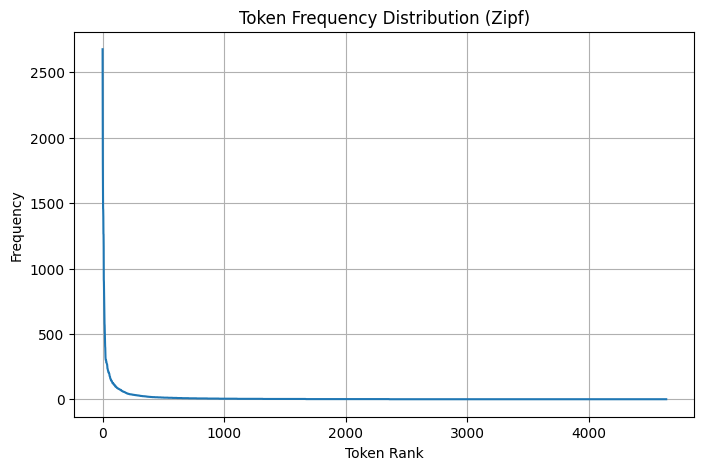

In [54]:
import json
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer

# -------------------------------
# Config
# -------------------------------
MODEL_NAME = "gpt2"        # or your existing tokenizer
CORPUS_PATH = "corpus.txt" # your academic/student corpus
TOP_N = 200                # how many tokens to print


# -------------------------------
# Load tokenizer & corpus
# -------------------------------
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Loading corpus...")
with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus_lines = f.readlines()


# -------------------------------
# Count token frequencies
# -------------------------------
freq = collections.Counter()

print("Tokenizing corpus...")
for line in tqdm(corpus_lines):
    tokens = tokenizer.encode(line, add_special_tokens=False)
    freq.update(tokens)

# Convert token IDs → strings
token_freq = {tokenizer.decode([tid]): count for tid, count in freq.items()}


# -------------------------------
# Save frequency file
# -------------------------------
with open("token_freq.json", "w") as f:
    json.dump(token_freq, f, indent=2)

print("\nSaved token frequencies → token_freq.json")


# -------------------------------
# Print top-N & rare tokens
# -------------------------------
print("\n⏶️ Top frequent tokens:")
for w, c in freq.most_common(TOP_N):
    print(f"{tokenizer.decode([w])}\t{c}")

print("\n❗️ Rare tokens:")
for w, c in freq.most_common()[-TOP_N:]:
    print(f"{tokenizer.decode([w])}\t{c}")


# -------------------------------
# Zipf Distribution Plot
# -------------------------------
sorted_counts = sorted(freq.values(), reverse=True)
plt.figure(figsize=(8,5))
plt.plot(sorted_counts)
plt.title("Token Frequency Distribution (Zipf)")
plt.xlabel("Token Rank")
plt.ylabel("Frequency")
plt.grid()
plt.savefig("token_zipf_curve.png")
print("\nSaved Zipf plot → token_zipf_curve.png")


# -------------------------------
# Subword Fragmentation Analysis
# -------------------------------
INTEREST_WORDS = [
    "reinforcement learning", "policy gradient", "actor-critic",
    "entropy regularization", "state transition", "Markov decision process",
    "optimization", "generalization", "empirical evaluation",
]

print("\n Subword Fragmentation:")
for phrase in INTEREST_WORDS:
    ids = tokenizer.encode(phrase, add_special_tokens=False)
    toks = tokenizer.convert_ids_to_tokens(ids)
    print(f"\nPhrase: {phrase}")
    print("Tokens:", toks)
    print("Token count:", len(toks))

## Notes & Next steps

- Replace dummy placeholders with real datasets (use `load_dataset`).
- Consider retrieval augmentation (RAG) and beam+nucleus candidate generation.
- For large-scale training, use multi-GPU + `accelerate` and checkpoint frequently.

---

Notebook file saved to `/mnt/data/GhostText_Assistant_notebook.ipynb`. Download it from the link below.